In [1]:
import cv2
from black.linegen import partial
from tqdm.contrib import itertools
from matplotlib import pyplot as plt
import numpy as np
from photon_canon.lut import LUT
from photon_canon.contrib.bio import hemoglobin_mus

C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\bio.py:122: SyntaxWarning: invalid escape sequence '\m'
  """Calculate the absorption coefficient (:math:`\mu_a`) as
C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\bio.py:284: SyntaxWarning: invalid escape sequence '\m'
  """Forwarding function to streamline :math:`\mathrm{[tHb]\,\&\,\mathrm{sO_2}` modelling. This function takes biological parameters and turns them


In [2]:
smoothing_fn = partial(cv2.GaussianBlur, ksize=(3, 3), sigmaX=2)
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True, simulation_id=110, smoothing_fn=smoothing_fn)
rng = np.random.default_rng(42)
H, W = 100, 100
wavelengths = np.arange(500, 610, 10)

C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\lut\utils.py:102: UserWarning: Smoothing is not applied to output dataframe. Reshape and apply manually if desired.
  return self.func(instance, owner, *args, **kwargs)


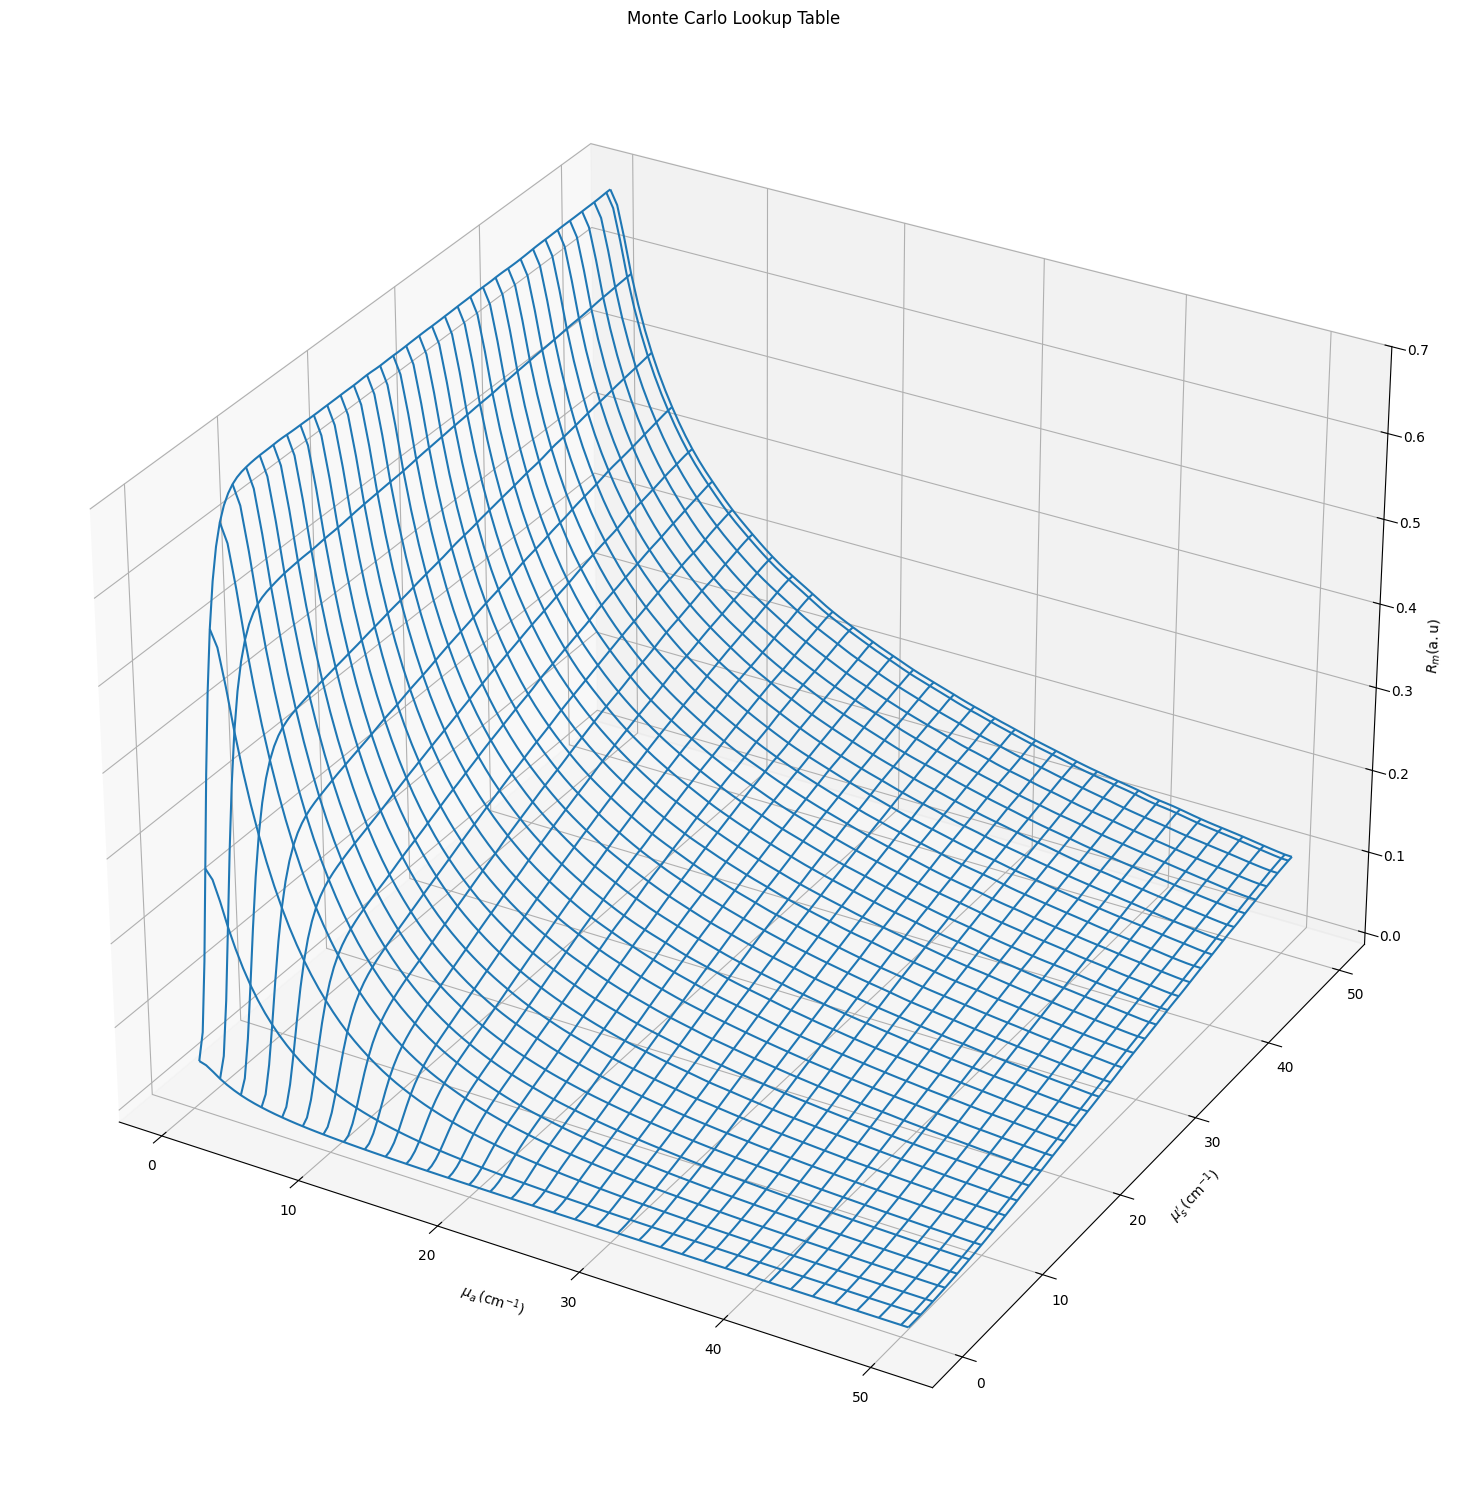

In [3]:
X, Y, Z = lut.surface()
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection='3d'))
ax.plot_wireframe(Y, X / 10, smoothing_fn(Z))
ax.set(xlabel=r"$\mu_a\, \mathrm{ (cm^{-1})}$", ylabel=r"$\mu_s'\, \mathrm{ (cm^{-1})}$", zlabel=r"$R_m \mathrm{ (a.u)}$", title="Monte Carlo Lookup Table")
savename = "".join(x for x in f"monte_carlo_{lut}.png" if x.isalnum())
fig.savefig(savename)
plt.tight_layout()
plt.show()

In [4]:
print(f'Current LUT version: {lut.simulation_id}')

Current LUT version: 110


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

mu_s' → max under 30.00 at A=5.61, B=8.18 with value=29.989
mu_a → max under 50.00 at [THb]=26.00, sO2=0.56 with value=49.993


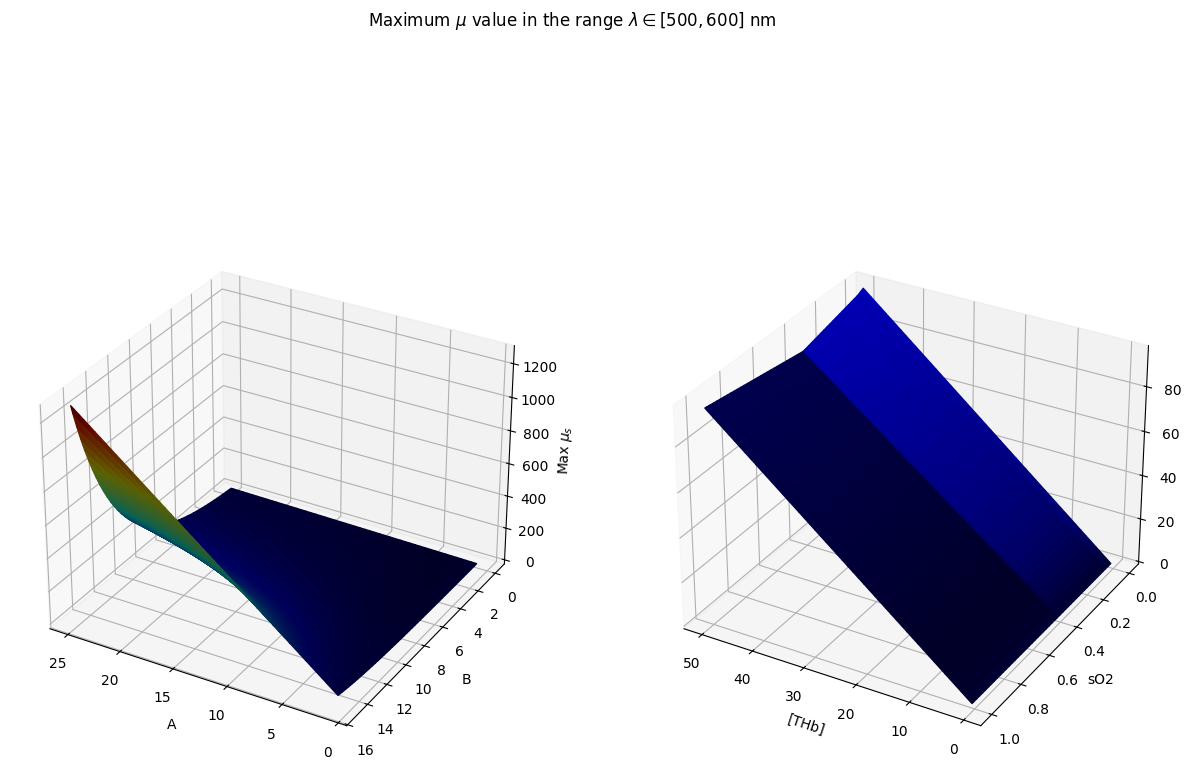

In [5]:
a_array = np.linspace(1, 25, 100)
b_array = np.linspace(0, 15, 100)
t_array = np.linspace(0.5, 50, 100)
s_array = np.linspace(0, 1, 100)
MUS, MUA = [], []
for a, b in itertools.product(a_array, b_array):
    mus_prime, _, _, = hemoglobin_mus(a, b, 0, 0, wavelengths)
    MUS.append(mus_prime)

for t, s in itertools.product(t_array, s_array):
    _, mua, _, = hemoglobin_mus(10, 1, t, s, wavelengths)
    MUA.append(mua)

threshold_mus = 30
threshold_mua = 50

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(15, 10))
fig.suptitle(r"Maximum $\mu$ value in the range $\lambda \in [500, 600]$ nm")

X, Y = np.meshgrid(b_array, a_array)
Z = np.reshape(np.max(MUS, axis=-1), (len(a_array), len(b_array)))
Z_masked = np.ma.masked_where(Z > threshold_mus, Z)
norm = plt.Normalize(vmin=np.min(Z), vmax=np.max(Z))
ax[0].plot_surface(Y, X, Z, facecolors=plt.cm.jet(norm(Z)))
ax[0].set(xlabel='A', ylabel='B', zlabel=r'Max $\mu_s$')
ax[0].view_init(30, 120)

idx = np.unravel_index(np.nanargmax(Z_masked), Z.shape)
best_a = a_array[idx[1]]
best_b = b_array[idx[0]]
print(f"mu_s' → max under {threshold_mus:.2f} at A={best_a:.2f}, B={best_b:.2f} with value={Z[idx]:.3f}")

X, Y = np.meshgrid(s_array, t_array)
Z = np.reshape(np.max(MUA, axis=-1), (len(t_array), len(s_array)))
Z_masked = np.ma.masked_where(Z > threshold_mua, Z)
ax[1].plot_surface(Y, X, Z, facecolors=plt.cm.jet(norm(Z)))
ax[1].set(xlabel='[THb]', ylabel='sO2', zlabel=r'Max $\mu_a$')
ax[1].view_init(30, 120)

idx = np.unravel_index(np.nanargmax(Z_masked), Z.shape)
best_thb = t_array[idx[1]]
best_so2 = s_array[idx[0]]
print(f"mu_a → max under {threshold_mua:.2f} at [THb]={best_thb:.2f}, sO2={best_so2:.2f} with value={Z[idx]:.3f}")

plt.show()

In [6]:
A = best_a
B = best_b
T = best_thb
S = best_so2
g = 0.9

a = np.random.uniform(high=A, size=(H, W))
b = np.random.uniform(high=B, size=(H, W))
t = np.random.uniform(high=T, size=(H, W))
s = np.random.uniform(high=1, size=(H, W))
Rd = np.zeros((len(wavelengths), H, W))
for i, j in itertools.product(range(H), range(W)):
    mu_s_prime, mu_a, _ = hemoglobin_mus(a[i, j], b[i, j], t[i, j], s[i,j], wavelengths)
    Rd[:, i, j] = lut(mu_s_prime / (1 - g), mu_a)

  0%|          | 0/10000 [00:00<?, ?it/s]

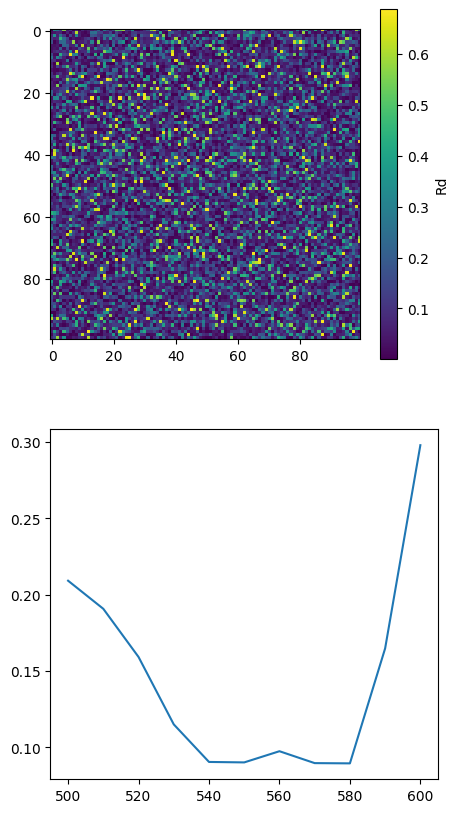

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10))
im = ax[0].imshow(np.nanmean(Rd, axis=0))
plt.colorbar(im, ax=ax[0], label='Rd')
ax[1].plot(wavelengths, np.nanmean(Rd, axis=(1, 2)))
plt.show()

In [8]:
from hsdfmpm.hsdfm.fit import fit_volume

def ready_model(a, b, t, s):
    mu_s_prime, mu_a, _ = hemoglobin_mus(a, b, t, s, wavelengths)
    mu_s = mu_s_prime / (1 - g)
    return lut(mu_s, mu_a)

# ready_model = functools.partial(model_from_hemoglobin, lut, wavelengths)
bounds = np.array([[0, 0, 0, 0], [np.inf, np.inf, np.inf, 1]])
guess = np.array([0.5 * A, 0.5 * S, 0.5 *  T, S])
param_image, score = fit_volume(model=ready_model, bounds=bounds, volume=Rd, x0=guess, use_multiprocessing=False)
af, bf, tf, sf = param_image

97.33% pixels fit acceptably, 2.67% did not.


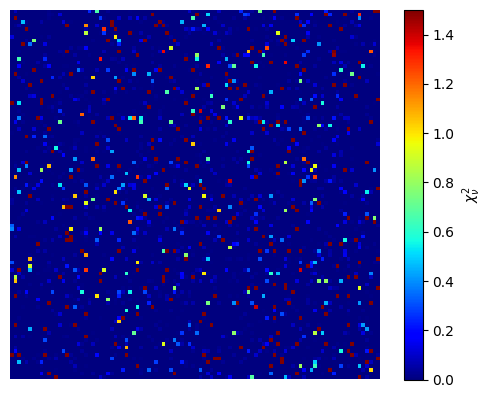

In [12]:
x2_mask = score <= 1.5
per_acceptable = 100 * np.sum(x2_mask) / (H * W)
print(f"{per_acceptable:.2f}% pixels fit acceptably, {100 - per_acceptable:.2f}% did not.")
plt.axis('off')
plt.imshow(np.clip(score, max=1.5), cmap='jet')
cbar = plt.colorbar()
cbar.set_label(r"$\chi^2_\nu$")
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

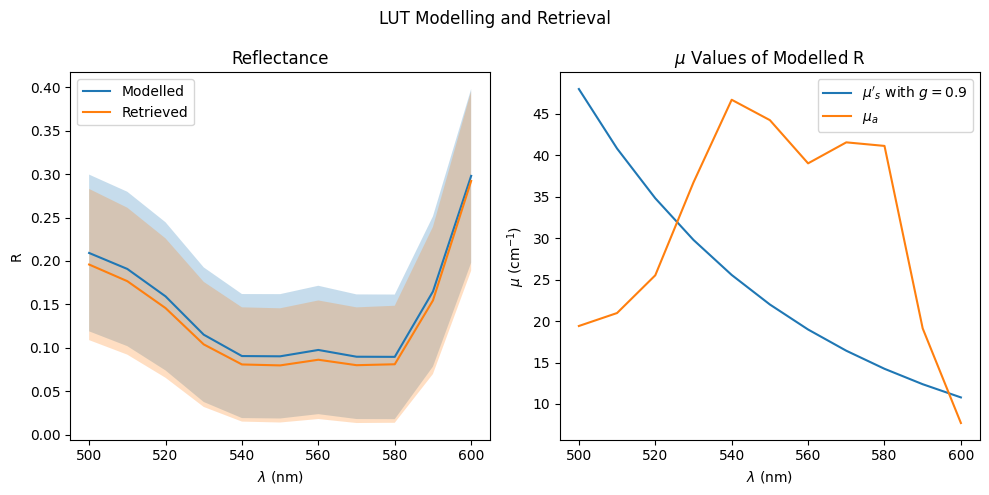

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('LUT Modelling and Retrieval')
x = np.nanmean(Rd, axis=(1, 2))
sig = 0.5 * np.nanstd(Rd, axis=(1, 2))
ax[0].plot(wavelengths, x, label='Modelled')
ax[0].fill_between(wavelengths, x - sig, x + sig, alpha=0.25)
Re = np.zeros((len(wavelengths), H, W))
for i, j in itertools.product(range(H), range(W)):
    if x2_mask[i, j]:
        mu_s_prime, mu_a, _ = hemoglobin_mus(af[i, j], bf[i, j], tf[i, j], sf[i,j], wavelengths)
        Re[:, i, j] = lut(mu_s_prime / (1 - g), mu_a)
x = np.nanmean(Re, axis=(1, 2))
sig = 0.5 * np.nanstd(Re, axis=(1, 2))
ax[0].plot(wavelengths, x, label='Retrieved')
ax[0].fill_between(wavelengths, x - sig, x + sig, alpha=0.25)
ax[0].set(title='Reflectance', xlabel=r'$\lambda$ (nm)', ylabel='R')
ax[0].legend()

mu_s, mu_a, _ = hemoglobin_mus(best_a, best_b, best_thb, best_so2, wavelengths)
ax[1].plot(wavelengths, mu_s, label=r"$\mu'_s$ with $g=0.9$")
ax[1].plot(wavelengths, mu_a, label=r'$\mu_a$')
ax[1].set(title=r'$\mu$ Values of Modelled R', xlabel=r'$\lambda$ (nm)', ylabel=r'$\mu$ (cm$^{-1}$)')
ax[1].legend()

plt.tight_layout()
plt.show()

C:\Users\jdivers\AppData\Local\Temp\ipykernel_332324\2756915499.py:12: RuntimeWarning: divide by zero encountered in divide
  mean_pe = 100 * np.nanmean((true - pred) / true),
C:\Users\jdivers\AppData\Local\Temp\ipykernel_332324\2756915499.py:13: RuntimeWarning: divide by zero encountered in divide
  md_ape = 100 * np.nanmedian(np.abs((true - pred) / true)),


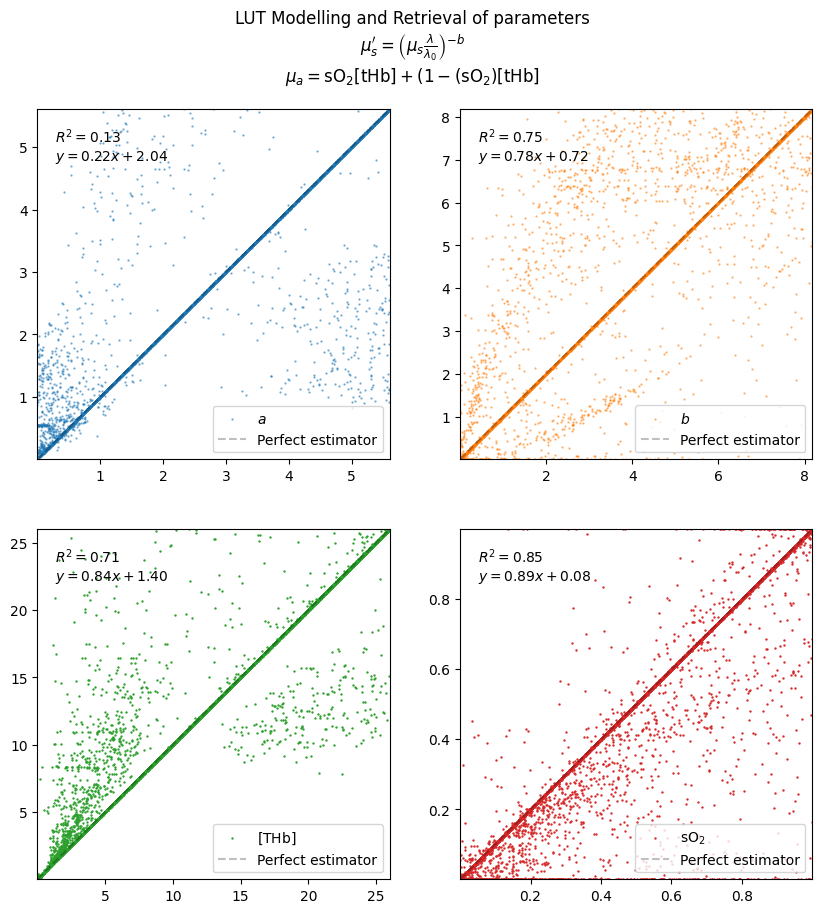

In [15]:
from sklearn.metrics import r2_score, explained_variance_score
def percent_rmse(true, pred):
    nn_mask = ~np.isnan(pred) & ~np.isnan(true)
    true = true[nn_mask]
    pred = pred[nn_mask]
    m, b = np.polyfit(true, pred, 1)
    return dict(
        nn_mask = nn_mask,
        mae = np.nanmean(np.abs(true - pred)),
        rmse = np.sqrt(np.nanmean((pred - true) ** 2)),
        mean_bias = np.nanmean(true - pred),
        mean_pe = 100 * np.nanmean((true - pred) / true),
        md_ape = 100 * np.nanmedian(np.abs((true - pred) / true)),
        r2 = r2_score(true[nn_mask], pred[nn_mask]),
        slope = m,
        intercept = b,
        ev = explained_variance_score(true[nn_mask], pred[nn_mask]),
        error_of_means = 100 * (np.nanmean(true[nn_mask]) - np.nanmean(pred[nn_mask])) / np.nanmean(true[nn_mask]),
        error_of_stdev = 100 * (np.nanstd(true[nn_mask]) - np.nanstd(pred)) / np.nanstd(true)
    )

def pprint_score(o, e, label="Round Trip Fit Metrics"):
    nn_mask, mae, rmse, mean_bias, mean_pe, md_ape, r2, ev, error_of_means, error_of_stdev = percent_rmse(o, e).values()

    print(f"\n{label}")
    print("=" * len(label))
    print(f"{'Metric':<35} {'Value':>12}")
    print("-" * 50)
    print(f"{'Mean Absolute Error (MAE)':<35} {mae:>12.4g}")
    print(f"{'Root Mean Squared Error (RMSE)':<35} {rmse:>12.4g}")
    print(f"{'Mean Bias':<35} {mean_bias:>12.4g}")
    print(f"{'Mean % Error':<35} {mean_pe:>12.2f}%")
    print(f"{'Median Absolute % Error':<35} {md_ape:>12.2f}%")
    print(f"{'R² Score':<35} {r2:>12.4f}")
    print(f"{'Explained Variance':<35} {ev:>12.4f}")
    print(f"{'Error in means':<35} {error_of_means:>12.4f}%")
    print(f"{'Error in stdevs':<35} {error_of_stdev:>12.4f}%")
    print()

a_error = percent_rmse(af[x2_mask], a[x2_mask])
b_error = percent_rmse(bf[x2_mask], b[x2_mask])
t_error = percent_rmse(tf[x2_mask], t[x2_mask])
s_error = percent_rmse(sf[x2_mask], s[x2_mask])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("LUT Modelling and Retrieval of parameters\n"
             r"$\mu_s' = \left(\mu_s\frac{\lambda}{\lambda_0}\right)^{-b}$" "\n"
             r"$\mu_a = \mathrm{sO_2[tHb]} + (1 - \left(\mathrm{sO_2}\right)\mathrm{[tHb]}$")

axes[0, 0].scatter(a[x2_mask], af[x2_mask], s=0.5, label="$a$", color="C0", alpha=0.5)
axes[0, 0].set(xlim=(a.min(), a.max()), ylim=(a.min(), a.max()))
axes[0, 0].text(0.05 * axes[0, 0].get_xlim()[1], 0.95 * axes[0, 0].get_ylim()[1],
                fr"$R^2 = {a_error["r2"]:.2f}$"
                "\n"
                fr"$y = {a_error["slope"]:.2f}x + {a_error["intercept"]:.2f}$",
                ha="left", va="top")

axes[0, 1].scatter(b[x2_mask], bf[x2_mask], s=0.5, label="$b$", color="C1", alpha=0.5)
axes[0, 1].set(xlim=(b.min(), b.max()), ylim=(b.min(), b.max()))
axes[0, 1].text(0.05 * axes[0, 1].get_xlim()[1], 0.95 * axes[0, 1].get_ylim()[1],
                fr"$R^2 = {b_error["r2"]:.2f}$"
                "\n"
                fr"$y = {b_error["slope"]:.2f}x + {b_error["intercept"]:.2f}$",
                ha="left", va="top")

axes[1, 0].scatter(t[x2_mask], tf[x2_mask], s=0.5, label=r"$\mathrm{[THb]}$", color="C2")
axes[1, 0].set(xlim=(t.min(), t.max()), ylim=(t.min(), t.max()))
axes[1, 0].text(0.05 * axes[1, 0].get_xlim()[1], 0.95 * axes[1, 0].get_ylim()[1],
                fr"$R^2 = {t_error["r2"]:.2f}$"
                "\n"
                fr"$y = {t_error["slope"]:.2f}x + {t_error["intercept"]:.2f}$",
                ha="left", va="top")

axes[1, 1].scatter(s[x2_mask], sf[x2_mask], s=0.5, label=r"$\mathrm{sO_2}$", color="C3")
axes[1, 1].set(xlim=(s.min(), s.max()), ylim=(s.min(), s.max()))
axes[1, 1].text(0.05 * axes[1, 1].get_xlim()[1], 0.95 * axes[1, 1].get_ylim()[1],
                fr"$R^2 = {s_error["r2"]:.2f}$"
                "\n"
                fr"$y = {s_error["slope"]:.2f}x + {s_error["intercept"]:.2f}$",
                ha="left", va="top")

for ax in axes.flatten():
    ax.axline((0,0), (1,1), linestyle='--', color='k', label='Perfect estimator', alpha=0.25)
    ax.legend(loc="lower right")

fig.savefig(f"round_trip_validation_plots_{savename}.png")
plt.show()